In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import gc

import torch.nn as nn
import torch
from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn.functional as F
import torchvision

from src import data_utils
from src.MNIST_model import MNIST_model
from src.train_config import Config as cfg
from src.MNIST_dataset import MNISTDataset
from src.custom_loss import CustomLoss
from src import train_utils

In [2]:
# initial_train_df = pd.read_csv("data/train.csv")
# print(initial_train_df.shape)
# initial_train_df.head()

# train_df = data_utils.get_dataframe_with_complete_array(initial_train_df)

# sample_train_df = train_df.sample(n=5)
# fig, ax = plt.subplots(1, 5, figsize=(15,15))
# fig.suptitle("5 Random samples", y=0.6)
# for i in range(0,5):
#     ax[i].imshow(sample_train_df["img_arr"].iloc[i], cmap="gray")
#     # ax[i].set_ylabel("xlabel") not working
#     ax[i].axis("off")
# plt.show()

In [3]:
train_set = torchvision.datasets.MNIST('/files/', train=True, download=True
                                       , transform=torchvision.transforms.Compose([
                                           torchvision.transforms.ToTensor()
                                        ]))
print(f"Train --- Shape: {list(train_set.train_data.size())} \n   - Mean: {train_set.train_data.float().mean()/255:.4f} \n   - Std: {train_set.train_data.float().std()/255:.4f}")

Train --- Shape: [60000, 28, 28] 
   - Mean: 0.1307 
   - Std: 0.3081


c:\Users\DannW\Anaconda3\envs\yolov7_env\lib\site-packages\torchvision\datasets\mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [4]:
transform = torchvision.transforms.Compose([
  torchvision.transforms.ToTensor(),
  torchvision.transforms.Normalize(
    (0.1307,), (0.3081,))
])

train_dataset = MNISTDataset('/files/', train=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=cfg.batch_size, shuffle=True)

validation_dataset = MNISTDataset('/files/', train=False, transform=transform)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=cfg.batch_size, shuffle=True)

print(f"Train: {len(train_dataset)}, Validation: {len(validation_dataset)}")

Train: 60000, Validation: 10000


In [5]:
model = MNIST_model().to(cfg.device)
optimizer = optim.SGD(model.parameters(), lr=cfg.lr, momentum=0.5)
criterion = torch.nn.CrossEntropyLoss() #CustomLoss()
model

MNIST_model(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Dropout2d(p=0.1, inplace=False)
  )
  (linear): Sequential(
    (0): Linear(in_features=25088, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=10, bias=True)
  )
)

In [6]:
from sklearn.metrics import accuracy_score

# if os.path.exists('results'):
#   os.system('rm -r results')

# os.mkdir('results')

def train_one_epoch(model, loader, criterion):
  model.train()
  loss_sum = 0.0
  for data, target in tqdm(loader):
    data = data.to(cfg.device)
    target = target.to(cfg.device)

    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    loss_sum += loss.item()
  print(f"Train Loss: {(loss_sum/len(loader)):.04f}")
  return loss_sum/len(loader)

def validation_one_epoch(model, loader, criterion):
  model.eval()
  loss_sum = 0
  y_true_epoch, y_pred_epoch = [], []
  with torch.no_grad():
    for data, target in tqdm(loader):
      data = data.to(cfg.device)
      target = target.to(cfg.device)

      y_pred = model(data)
      loss_sum += criterion(y_pred, target).item()
      y_pred = F.softmax(y_pred, dim=1)
      y_true_epoch.append(target.cpu().numpy())
      y_pred_epoch.append(np.argmax(y_pred.cpu().numpy(), axis=1))

  y_true_epoch = np.concatenate(y_true_epoch, axis=0)
  y_pred_epoch = np.concatenate(y_pred_epoch, axis=0)
  scores = accuracy_score(y_true_epoch, y_pred_epoch) #[average_precision_score(y_true_epoch[:,i], y_pred_epoch[:,i]) for i in range(cfg.num_classes)]
  mean_score = np.mean(scores)
  print(f"Validation loss: {loss_sum/len(loader):.4f}, Accuracy: {mean_score:.05f}")

  return loss_sum/len(loader), mean_score, y_true_epoch, y_pred_epoch

Epoch: 0


100%|██████████| 469/469 [00:34<00:00, 13.43it/s]


Train Loss: 0.4027


100%|██████████| 79/79 [00:03<00:00, 21.00it/s]


Validation loss: 0.1702, Accuracy: 0.94930

Saving Model ...
Epoch: 1


100%|██████████| 469/469 [00:28<00:00, 16.52it/s]


Train Loss: 0.1358


100%|██████████| 79/79 [00:04<00:00, 16.57it/s]


Validation loss: 0.0929, Accuracy: 0.97330

Saving Model ...
Epoch: 2


100%|██████████| 469/469 [00:25<00:00, 18.24it/s]


Train Loss: 0.0945


100%|██████████| 79/79 [00:03<00:00, 23.90it/s]


Validation loss: 0.0641, Accuracy: 0.97960

Saving Model ...
Epoch: 3


100%|██████████| 469/469 [00:22<00:00, 21.10it/s]


Train Loss: 0.0739


100%|██████████| 79/79 [00:03<00:00, 24.59it/s]


Validation loss: 0.0595, Accuracy: 0.98190

Saving Model ...
Epoch: 4


100%|██████████| 469/469 [00:21<00:00, 21.51it/s]


Train Loss: 0.0617


100%|██████████| 79/79 [00:03<00:00, 24.76it/s]


Validation loss: 0.0493, Accuracy: 0.98520

Saving Model ...
Epoch: 5


100%|██████████| 469/469 [00:22<00:00, 20.82it/s]


Train Loss: 0.0545


100%|██████████| 79/79 [00:03<00:00, 24.95it/s]


Validation loss: 0.0452, Accuracy: 0.98620

Saving Model ...
Epoch: 6


100%|██████████| 469/469 [00:21<00:00, 21.50it/s]


Train Loss: 0.0479


100%|██████████| 79/79 [00:03<00:00, 22.01it/s]


Validation loss: 0.0457, Accuracy: 0.98640

Saving Model ...
Epoch: 7


100%|██████████| 469/469 [00:22<00:00, 20.91it/s]


Train Loss: 0.0432


100%|██████████| 79/79 [00:03<00:00, 25.03it/s]


Validation loss: 0.0444, Accuracy: 0.98640
Epoch: 8


100%|██████████| 469/469 [00:22<00:00, 20.62it/s]


Train Loss: 0.0385


100%|██████████| 79/79 [00:04<00:00, 18.79it/s]


Validation loss: 0.0422, Accuracy: 0.98700

Saving Model ...
Epoch: 9


100%|██████████| 469/469 [00:26<00:00, 17.43it/s]


Train Loss: 0.0352


100%|██████████| 79/79 [00:03<00:00, 23.00it/s]


Validation loss: 0.0400, Accuracy: 0.98750

Saving Model ...
Epoch: 10


100%|██████████| 469/469 [00:25<00:00, 18.06it/s]


Train Loss: 0.0325


100%|██████████| 79/79 [00:03<00:00, 24.64it/s]


Validation loss: 0.0424, Accuracy: 0.98710
Epoch: 11


100%|██████████| 469/469 [00:22<00:00, 20.41it/s]


Train Loss: 0.0305


100%|██████████| 79/79 [00:02<00:00, 27.23it/s]


Validation loss: 0.0386, Accuracy: 0.98760

Saving Model ...
Epoch: 12


100%|██████████| 469/469 [00:20<00:00, 22.66it/s]


Train Loss: 0.0272


100%|██████████| 79/79 [00:03<00:00, 24.17it/s]


Validation loss: 0.0392, Accuracy: 0.98800

Saving Model ...
Epoch: 13


100%|██████████| 469/469 [00:22<00:00, 21.21it/s]


Train Loss: 0.0260


100%|██████████| 79/79 [00:03<00:00, 25.05it/s]


Validation loss: 0.0483, Accuracy: 0.98490
Epoch: 14


100%|██████████| 469/469 [00:22<00:00, 21.24it/s]


Train Loss: 0.0234


100%|██████████| 79/79 [00:03<00:00, 25.09it/s]


Validation loss: 0.0406, Accuracy: 0.98680
Epoch: 15


100%|██████████| 469/469 [00:21<00:00, 21.44it/s]


Train Loss: 0.0231


100%|██████████| 79/79 [00:03<00:00, 19.89it/s]


Validation loss: 0.0396, Accuracy: 0.98690
Epoch: 16


100%|██████████| 469/469 [00:25<00:00, 18.23it/s]


Train Loss: 0.0199


100%|██████████| 79/79 [00:03<00:00, 24.74it/s]


Validation loss: 0.0394, Accuracy: 0.98780
Epoch: 17


100%|██████████| 469/469 [00:24<00:00, 19.44it/s]


Train Loss: 0.0189


100%|██████████| 79/79 [00:03<00:00, 25.03it/s]


Validation loss: 0.0362, Accuracy: 0.98810

Saving Model ...
Epoch: 18


100%|██████████| 469/469 [00:27<00:00, 17.32it/s]


Train Loss: 0.0166


100%|██████████| 79/79 [00:03<00:00, 24.95it/s]


Validation loss: 0.0359, Accuracy: 0.98830

Saving Model ...
Epoch: 19


100%|██████████| 469/469 [00:22<00:00, 20.82it/s]


Train Loss: 0.0166


100%|██████████| 79/79 [00:03<00:00, 21.81it/s]


Validation loss: 0.0386, Accuracy: 0.98770
Epoch: 20


100%|██████████| 469/469 [00:30<00:00, 15.40it/s]


Train Loss: 0.0162


100%|██████████| 79/79 [00:03<00:00, 21.52it/s]


Validation loss: 0.0412, Accuracy: 0.98740
Epoch: 21


100%|██████████| 469/469 [00:30<00:00, 15.27it/s]


Train Loss: 0.0145


100%|██████████| 79/79 [00:03<00:00, 21.98it/s]


Validation loss: 0.0398, Accuracy: 0.98850

Saving Model ...
Epoch: 22


100%|██████████| 469/469 [00:30<00:00, 15.27it/s]


Train Loss: 0.0132


100%|██████████| 79/79 [00:03<00:00, 21.64it/s]


Validation loss: 0.0393, Accuracy: 0.98880

Saving Model ...
Epoch: 23


100%|██████████| 469/469 [00:30<00:00, 15.25it/s]


Train Loss: 0.0130


100%|██████████| 79/79 [00:03<00:00, 22.07it/s]


Validation loss: 0.0375, Accuracy: 0.98820
Epoch: 24


100%|██████████| 469/469 [00:30<00:00, 15.26it/s]


Train Loss: 0.0118


100%|██████████| 79/79 [00:03<00:00, 21.53it/s]


Validation loss: 0.0385, Accuracy: 0.98820
Epoch: 25


100%|██████████| 469/469 [00:30<00:00, 15.26it/s]


Train Loss: 0.0108


100%|██████████| 79/79 [00:03<00:00, 19.83it/s]


Validation loss: 0.0388, Accuracy: 0.98850
Epoch: 26


100%|██████████| 469/469 [00:30<00:00, 15.31it/s]


Train Loss: 0.0107


100%|██████████| 79/79 [00:03<00:00, 21.48it/s]


Validation loss: 0.0407, Accuracy: 0.98850
Epoch: 27


100%|██████████| 469/469 [00:30<00:00, 15.34it/s]


Train Loss: 0.0093


100%|██████████| 79/79 [00:03<00:00, 20.20it/s]


Validation loss: 0.0432, Accuracy: 0.98810
Epoch: 28


100%|██████████| 469/469 [00:30<00:00, 15.21it/s]


Train Loss: 0.0090


100%|██████████| 79/79 [00:03<00:00, 21.30it/s]


Validation loss: 0.0397, Accuracy: 0.98870
Epoch: 29


100%|██████████| 469/469 [00:31<00:00, 14.76it/s]


Train Loss: 0.0086


100%|██████████| 79/79 [00:04<00:00, 18.57it/s]


Validation loss: 0.0421, Accuracy: 0.98760


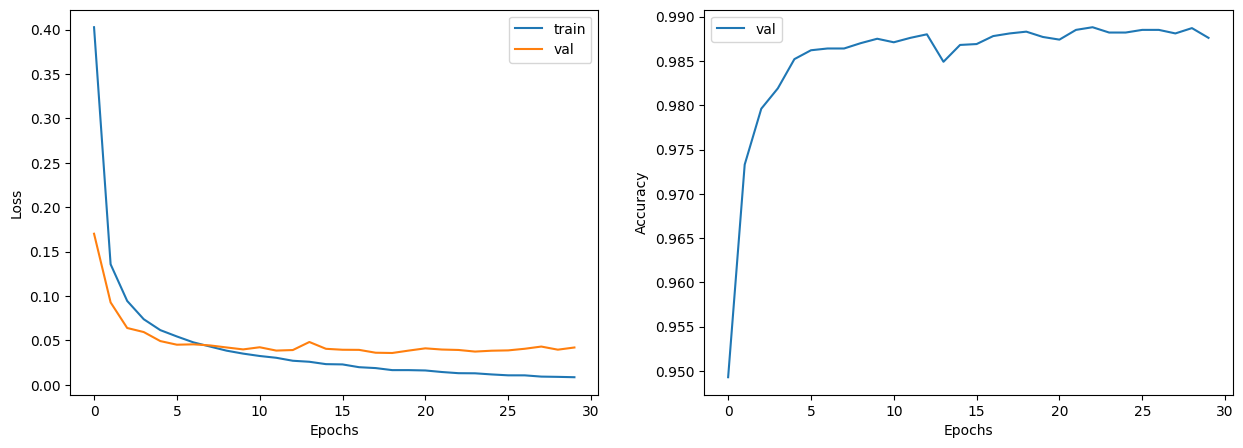

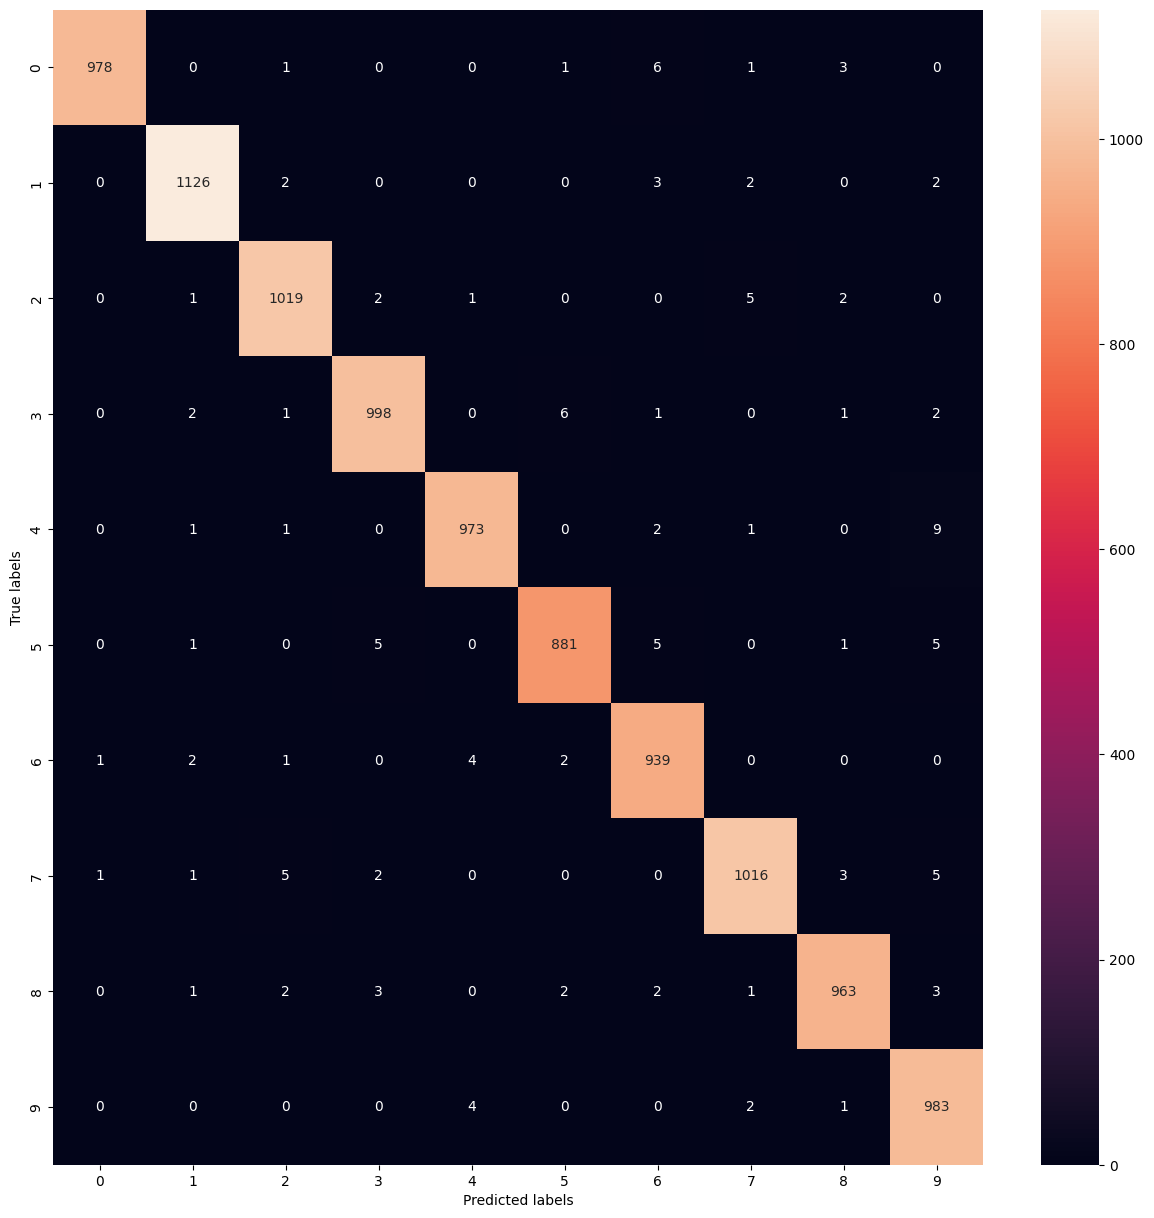

{5: 17, 7: 17, 4: 14, 8: 14, 3: 13, 0: 12, 2: 11, 6: 10, 1: 9, 9: 7}


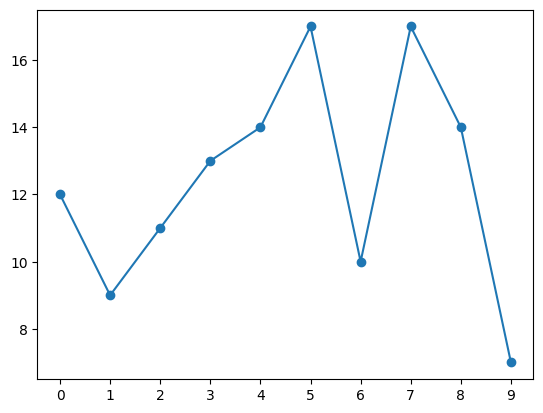

23646

In [7]:
# Training 
max_score = 0.0
loss = {"train": [], "val":[]}
acc = {"train": [], "val":[]}
for n_iter in range(1, cfg.n_iters+1):
  for epoch in range(cfg.num_epochs):
    print("="*50)
    print(f"Epoch: {epoch}")
    train_loss = train_one_epoch(model, train_dataloader, criterion)
    val_loss, score, labels, y_preds = validation_one_epoch(model, validation_dataloader, criterion)
    loss["train"].append(train_loss), loss["val"].append(val_loss), acc["val"].append(score)

    if score > max_score:
      max_score = np.mean(score)
      torch.save(model.state_dict(), "results/best_model_state_"+cfg.model_name+".h5")
      print("\nSaving Model ...")
    print("="*50)

  train_utils.plot_losses(loss, acc)
  conf_matrix = train_utils.get_and_plot_matrix_confusion(y_preds, labels)
  worst_classes_l = train_utils.get_worst_classes(conf_matrix)
  criterion = CustomLoss(worst_classes_l=worst_classes_l)

gc.collect()